<a href="https://colab.research.google.com/github/yooga228/Fall-AI/blob/main/Auto_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Intall autodistil

In [5]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Image data preparation

In [7]:
!mkdir {HOME}/images

mkdir: cannot create directory ‘/content/images’: File exists


In [14]:
!unzip /content/images/car.zip -d /content/images

Archive:  /content/images/car.zip
replace /content/images/car/104.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import roboflow

roboflow.login()

dataset = roboflow.download_dataset(dataset_url="https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16", model_format="yolov8")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.81, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to TACO:-Trash-Annotations-in-Context-Dataset-16 in yolov8:: 100%|██████████| 7204/7204 [00:01<00:00, 5549.77it/s]


In [ ]:
%mv {HOME}/TACO:-Trash-Annotations-in-Context-Dataset-16/valid/images/* {HOME}/images

## Autolabel dataset

In [8]:
%pwd

'/content'

In [9]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "car": "target",
})

In [10]:
DATASET_DIR_PATH = f"{HOME}/dataset"

In [11]:
IMAGE_DIR_PATH = "/content/car"

In [12]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
Labeling /content/car/98.jpg:   0%|          | 0/5 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /conten

Labeled dataset created - ready for distillation.


## Display dataset sample

In [13]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [14]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

4

In [15]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

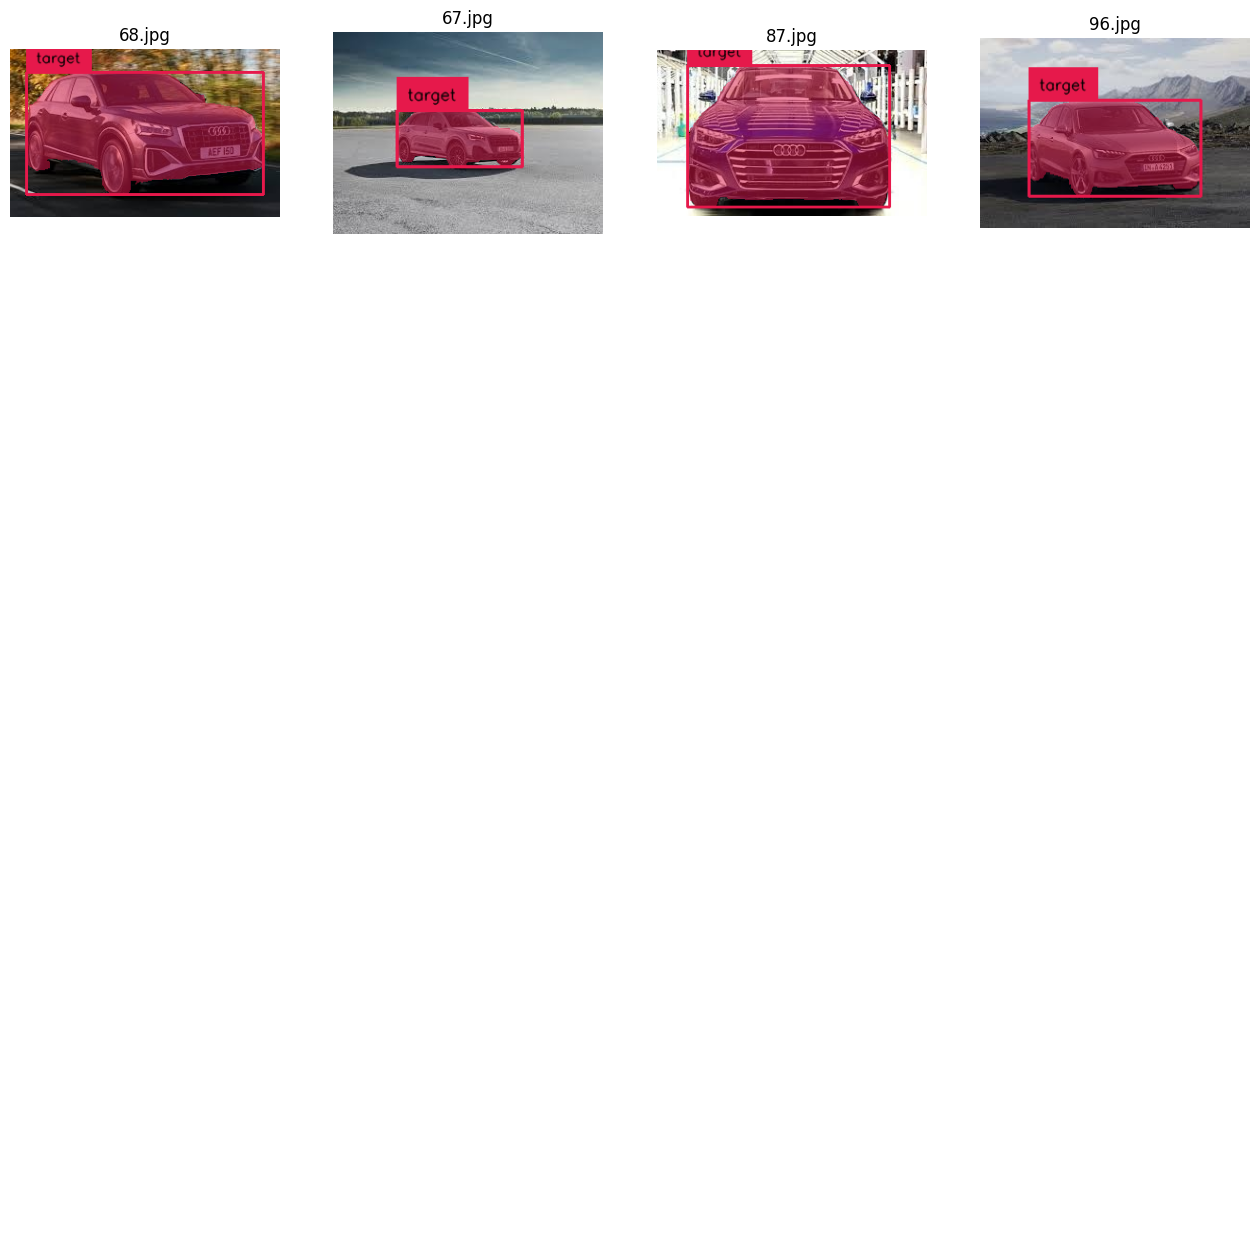

In [16]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)